In [ ]:
pip install python-terrier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 22.7 MB/s 
     |████████████████████████████████| 69 kB 8.2 MB/s 
     |████████████████████████████████| 303 kB 36.5 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 45 kB 2.1 MB/s 
     |████████████████████████████████| 126 kB 41.9 MB/s 
     |████████████████████████████████| 1.2 MB 43.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 72 kB 1.6 MB/s 
     |████████████████████████████████| 294 kB 47.3 MB/s 
     |████████████████████████████████| 285 kB 53.9 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.8.1-py3-none-any.whl size=104091 sha256=00e91599023a9243a49944af5830bf13fdd31015c57db

In [ ]:
import pyterrier as pt
pt.init()


terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
mod_queries = np.load('/content/drive/MyDrive/IRDM/queries_doc_test3.npy',allow_pickle='TRUE').item()

In [ ]:
query_master= np.load('/content/drive/MyDrive/IRDM/master_set_docs.npy',allow_pickle='TRUE').item()

In [ ]:
def make_experiment_file(dict_input):
  output_file={}
  for keys in dict_input.keys():
    for k in range(len(dict_input[keys])):
      if keys not in output_file.keys():
        output_file.update({keys:[dict_input[keys][k][0]]})
      else:
        output_file[keys].append(dict_input[keys][k][0])
  return output_file

In [ ]:
master_doc_file=make_experiment_file(query_master)

In [ ]:
query_master_file=make_experiment_file(mod_queries)

In [ ]:
def jaccard_similarity_score(document_1,document_2): 
    document_1=set(document_1)
    document_2=set(document_2)
    inter=document_1.intersection(document_2)
    union = document_1.union(document_2)
    return float(len(inter)) / len(union)

def calculate_similarity(query_file,doc_file):
  calc_score={}
  for keys in query_file.keys():
    for docs in doc_file.keys():
      if keys not in calc_score.keys():
        calc_score.update({keys:[[docs,jaccard_similarity_score(query_file[keys],doc_file[docs])]]})
      else:
        calc_score[keys].append([docs,jaccard_similarity_score(query_file[keys],doc_file[docs])])
  return calc_score

def get_x(input_file):
  send_x={}
  for keys in input_file.keys():
    for i in range(len(input_file[keys])):
      if keys not in send_x.keys():
        send_x.update({keys:[input_file[keys][i][1]]})
      else:
        send_x[keys].append(input_file[keys][i][1])
  return send_x

def return_relevant(mapping_file,score_file):
  just_rel={}
  for keys in score_file.keys():
    for i in range(len(score_file[keys])):
        if score_file[keys][i][0] in mapping_file[keys]:
          if keys not in just_rel.keys():
            just_rel.update({keys:[score_file[keys][i]]})
          else:
            just_rel[keys].append(score_file[keys][i])
  return just_rel

def get_non_relevant_no_rank(mapper,doc):
  non_rel={}
  for keys in doc.keys():
    for i in range(len(doc[keys])):
        if doc[keys][i][0] not in mapper[keys]:
          if keys not in non_rel.keys():
            non_rel.update({keys:[doc[keys][i]]})
          else:
            non_rel[keys].append(doc[keys][i])
  return non_rel

In [ ]:
total_score=calculate_similarity(query_master_file,master_doc_file)

In [ ]:
total_score.keys()

dict_keys(['9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '58', '57'])

In [ ]:
qrels_path=("/content/drive/MyDrive/IRDM/podcasts_2020_test.qrels")
qrels = pt.io.read_qrels(qrels_path)
qrels["qid"]=qrels["qid"].astype(int)
qrels["qid_int"]=qrels["qid"].astype(int)
qrels["qid"]=qrels["qid"]-1
qrels["qid_int"]=qrels["qid"].astype(int)
qrels["qid"]=qrels["qid"].astype("str")
qrels['rel_files']=list(qrels["docno"].apply(lambda x: x.split(":")[-1].split('.')[0]))
query_mapper={}
for i in range(qrels["qid_int"].min(),qrels["qid_int"].max()+1):
  query_mapper.update({str(i+1):list(qrels[qrels["qid"]==str(i)]["rel_files"])})


In [ ]:
total_non_rel=get_non_relevant_no_rank(query_mapper,total_score)

In [ ]:
total_rel = return_relevant(query_mapper,total_score)

In [ ]:
X_rel=get_x(total_rel)

In [ ]:
X_non_rel=get_x(total_non_rel)

In [ ]:
X_rel['47']=[]
X_rel['50']=[]


In [ ]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

def create_plot_master(relevant_doc,non_relevant_doc):
  top_num=list(range(9,59))
  data_record=pd.DataFrame([])
  for t in top_num:
    muster = {'Jaccard_Similarity':relevant_doc[str(t)],'Topic' : [str(t)]*len(relevant_doc[str(t)]),'Relevant':['Yes']*len(relevant_doc[str(t)])}
    df=pd.DataFrame.from_dict(muster)
    data_record=pd.concat([data_record,df])
  for t in top_num:
    muster = {'Jaccard_Similarity':non_relevant_doc[str(t)],'Topic' : [str(t)]*len(non_relevant_doc[str(t)]),'Relevant':['No']*len(non_relevant_doc[str(t)])}
    df=pd.DataFrame.from_dict(muster)
    data_record=pd.concat([data_record,df])
  return data_record

In [ ]:
plot_data=create_plot_master(X_rel,X_non_rel)

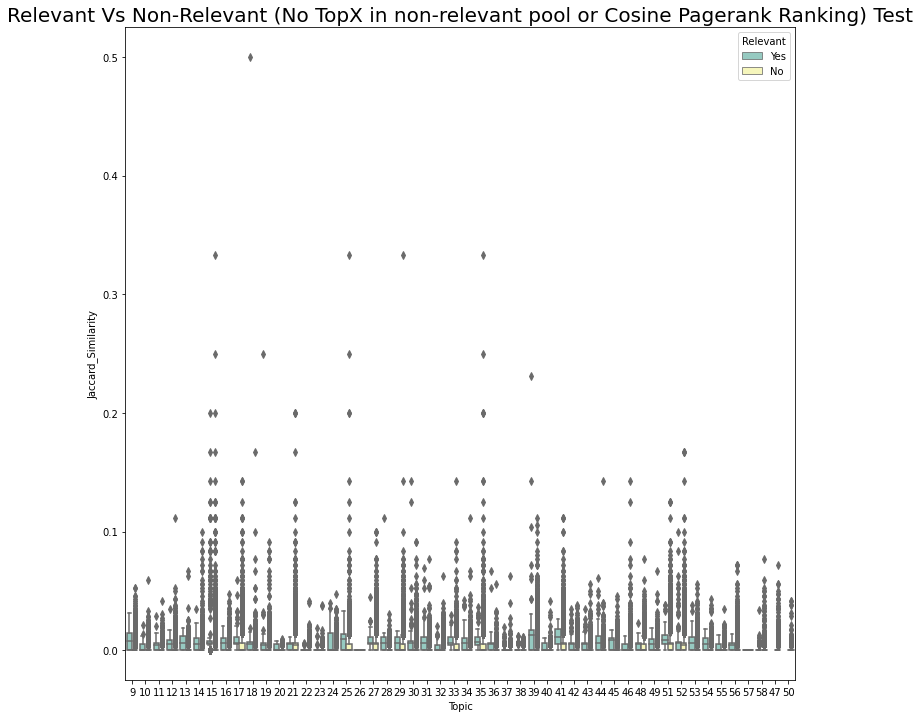

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
ax = sns.boxplot(x="Topic", y="Jaccard_Similarity", hue="Relevant",
                 data=plot_data, palette="Set3")
plt.title('Relevant Vs Non-Relevant (No TopX in non-relevant pool or Cosine Pagerank Ranking) Test',fontsize=20)
plt.savefig('/content/drive/MyDrive/IRDM/jaccard_scores_overall_test.png')

In [ ]:
import scipy
def save_table(non_rel,rel,file_loc_name):
  empty_table=pd.DataFrame([])
  for topics in list(range(9,59)):
    gather = {'Topic': str(topics) ,'Relevant_docs' : len(rel[str(topics)]),'Non_Relevant_docs':len(non_rel[str(topics)])}
    hold=pd.DataFrame(gather,index=[topics-1])
    empty_table=pd.concat([empty_table,hold])
  empty_table.to_csv(file_loc_name)

In [ ]:
save_table(X_non_rel,X_rel,'/content/drive/MyDrive/IRDM/Overall_Table_with_statistics_test.csv')